**original of this example : https://towardsdatascience.com/from-scratch-bayesian-inference-markov-chain-monte-carlo-and-metropolis-hastings-in-python-ef21a29e25a**


# From Scratch: Bayesian Inference, Markov Chain Monte Carlo and Metropolis Hastings, in python

In one of the courses during my data science degree, I came across a technique called Markov Chain Monte Carlo, or as it's more commonly referred to, MCMC. The description for this method stated something along the lines of: MCMC is a class of techniques for sampling from a probability distribution and can be used to estimate the distribution of parameters given a set of observations.

Back then, I did not think much of it. I thought, "oh it's just another sampling technique", and I decided I'd read on it when I'd practically need it. This need never emerged, or perhaps it did and I wrongly used something else.

## So why the interest now?

Recently, I have seen a few discussions about MCMC and some of its implementations, specifically the Metropolis-Hastings algorithm and the PyMC3 library. $Markov \: Chain\: Monte\: Carlo\: in\: Python\: - \:A \:Complete\: Real$-$World \:Implementation$ was the article that caught my attention the most. In it, William Koehrsen explains how he was able to learn the approach by applying it to a real world problem: to estimate the parameters of a logistic function that represents his sleeping patterns.


\begin{equation} P(sleep/t,\alpha,\beta)=\dfrac{1}{1+e^{\beta t + \alpha}}  \end{equation}


Mr. Koehrsen uses the PyMC3 implementation of the Metropolis-Hastings algorithm to estimate $\beta$ and $\alpha$, thus computing the entire parameter space, and deriving the most likely logistic model.

## So why am I talking about all that?

I this article, I propose to implement from scratch, my own version of the Metropolis-Hastings algorithm to find parameter distributions for a dummy data example and then of a real world problem.

I figured that if I get my hands dirty, I might finally be able to understand it. I will only use numpy to implement the algorithm, and matplotlib to draw pretty things. Alternatively, scipy can be used to compute the density functions, but I will also show how to implement them using numpy.

## Flow of the article:

    * At first, I will introduce Bayesian inference, MCMC-MH and their mathematical components.
    * Second, I will explain the algorithm using dummy data.
    * Third, I will apply it to a real world problem.

# Part 1: Bayesian inference, Markov Chain Monte Carlo, and Metropolis-Hastings

## A bird's eye view on the philosophy of probabilities

In order to talk about Bayesian inference and what follows it, I shall first explain what the Bayesian view of probability is, and situate it within its historical context

### Frequentist vs Bayesian thinking

There are two major interpretations to probabilities: Bayesian and Frequentist. 

From a **Frequentist's** perspective, probabilities represent long term frequencies with which events occur. A frequentist can say that the probability of having tails from a coin toss is equal to 0.5 *on the long run*. Each new experiment, can be considered as one of an infinite sequence of possible repetitions of the same experiment. The idea is that there is *no* belief in a frequentist's view of probability. The probability of event $x$ happening out of n trials is equal to the following frequency: $P(x)=\dfrac{n_x}{n}$, and the true probability is reached when $n->\infty$. Frequentists will never say "I am 45% (0.45) sure that there is lasagna for lunch today", since this does not happen on the long run. Commonly, a frequentist approach is referred to as the *objective* approach since there is no expression of belief and/or prior events in it.

On the other hand, in **Bayesian** thinking, probabilities are treated as an expression of belief. Therefore it is perfectly reasonable for a Bayesian to say "I am 50% (0.5) sure that there is lasagna for lunch today". By combining *prior* beliefs and current events (the *evidence*) one can compute the *posterior*, the belief that there is lasagna today. The idea behind Bayesian thinking is to keep updating the beliefs as more evidence is provided. Since this approach deals with belief, it is usually referred to as the *subjective* view on probability.

### Bayesian inference


<img src="data/Thomas-Bayes.jpg" style="width: 400px;"> $\quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad $  *A supposed portrait of Thomas Bayes, an English statistician, philosopher, and theologian. Image Credit: [Farnam Street](https://fs.blog/2018/09/bayes-theorem/).*

In the philosophy of decision making, Bayesian inference is closely related to Bayesian probability, in the sense that it manipulates priors, evidence, and likelihood to compute the posterior. Given some event B, what is the probability that event A occurs?. This is answered by Bayes' famous formula: $P(A/B)=\dfrac{P(B/A)P(A)}{P(B)}$

* $P(A/B)$ is the **posterior**. What we wish to compute.

* $P(B/A)$ is the **likelihood**. Assuming A occured, how likely is B.

* $P(A)$ is the **prior**. How likely the event $A$ is regardless of evidence.

* $P(B)$ is the **evidence**. How likely the evidence $B$ is regardless of the event.

In our case, we are mostly interested in the specific formulation of Bayes' formula:

$P(\theta/D)=\dfrac{P(D/\theta)P(\theta)}{P(D)}$ where, $P(\theta/D)$ is the **posterior**, $P(D/\theta)$ is the **likelihood**, $P(\theta)$ is the **prior** and $P(D)$ is the **evidence**.

We would like to find the most likely distribution of $\theta$, the parameters of the model explaining the data, D.



Computing some of these probabilities can be tedious, especially the evidence $P(D)$. Also, other problems can arise such as those of ensuring conjugacy, which I will not dive into in this article. Luckily, some techniques, namely MCMC, allow us to sample from the posterior, and a draw distributions over our parameters without having to worry about computing the evidence, nor about conjugacy.

### Markov Chain Monte Carlo


MCMC allows us to draw samples from any distribution that we can't sample from directly. It can be used to sample from the posterior distribution over parameters.
It has seen much success in many applications, such as computing the distribution of parameters, given a set of observations and some prior belief, and also computing high dimensional integrals in physics and in digital communications.

Bottom line: **It can be used to compute the distribution over the parameters, given a set of observations and a prior belief.**

### Metropolis-Hastings

MCMC is a class of methods. Metropolis-Hastings is a specific implementation of MCMC. It works well in high dimensional spaces as opposed to Gibbs sampling and rejection sampling.

This technique requires a simple distribution called the **proposal distribution** (Which I like to call **transition model**... [it might be due to $T\left(x_{i+1} \mid x_i\right)=q\left(x_{i+1} \mid x_i\right) \times p_{\text {acc }}\left(x_{i+1} \mid x_i\right)$ ] ) $Q(\theta^\prime/\theta)$ to help draw samples from an intractable posterior distribution $P(\Theta=\theta/D)$. 


**Metropolis-Hastings uses $Q$ to randomly walk in the distribution space, accepting or rejecting jumps to new positions based on how likely the sample is. This "memoriless" random walk is the "Markov Chain" part of MCMC.**

The "likelihood" of each new sample is decided by a function $f$ . That's why $f$ must be proportional to the posterior we want to sample from. f is commonly chosen to be a probability density function that expresses this proportionality.

To get a new position of the parameter, just take our current one $\theta$, and propose a new one $\theta^\prime$, that is a random sample drawn from $Q(\theta^\prime/\theta)$. Often this is a symmetric distribution. For instance, a normal distribution with mean $\theta$ and some standard deviation $\sigma$: $Q(\theta^\prime/\theta) = \mathcal{N}(\theta, \sigma)$


To decide if $\theta^\prime$ is to be accepted or rejected, the following ratio must be computed for each new value of $\theta^\prime$: $\dfrac{P(\theta^\prime/D)}{P(\theta/D)}$. Using Bayes' formula this can be easily re-formulated as: $\dfrac{P(D/\theta^\prime)P(\theta^\prime)}{P(D/\theta)P(\theta)}$ (The evidence $P(D)$ is simply crossed out during the division).  $\dfrac{P(D/\theta^\prime)P(\theta^\prime)}{P(D/\theta)P(\theta)}$ is also equivalent to $\dfrac{\prod_i^nf(d_i/\Theta=\theta^\prime)P(\theta^\prime)}{\prod_i^nf(d_i/\Theta=\theta)P(\theta)}$



$$\begin{equation} P(\text{accept}) = \begin{cases}\dfrac{\prod_i^nf(d_i/\Theta=\theta^\prime)P(\theta^\prime)}{\prod_i^nf(d_i/\Theta=\theta)P(\theta)}, & \prod_i^nf(d_i/\Theta=\theta)P(\theta)>\prod_i^nf(d_i/\Theta=\theta^\prime)P(\theta^\prime) \\  1, & \prod_i^nf(d_i/\Theta=\theta)P(\theta)\leq \prod_i^nf(d_i/\Theta=\theta^\prime)P(\theta^\prime) \end{cases} \end{equation}$$

This means that if a θ' is more likely than the current θ, then we always accept θ'. If it is less likely than the current θ, then we might accept it or reject it randomly with decreasing probability, the less likely it is.


*Note: The prior components are often crossed if there is no preference or restrictions on the parameters.*


#### Metropolis-Hastings Algorithm:
* given:
    * $f$, the PDF of the distribution to sample from
    * $Q$, the transition model
    * $\theta_0$, a first guess for $\theta$
    * $\theta = \theta_0$
    
* for $n$ iterations
    * $p =  f(D/\Theta=\theta)P(\theta)$
    *  $\theta^\prime = Q(\theta_i)$ 
    *  $p^\prime = f(D/\Theta=\theta^\prime)P(\theta^\prime)$ 
    *  $ratio = \dfrac{p^\prime}{p}$ 
    * generate a uniform random number $r$ in [0,1]
    *  if $r<ratio$: 
        * set $\theta_i = \theta^\prime$
                        

# Part 2: Dummy data example
## Step 1: Data generation

We generate 30,000 samples from a normal distribution with $\mu$ = 10, and $\sigma$= 3, but we can only observe 1000 of them.

In [1]:
import numpy as np
import scipy
import scipy.stats
import matplotlib as mpl   
import matplotlib.pyplot as plt
%matplotlib inline

9.976226220606643

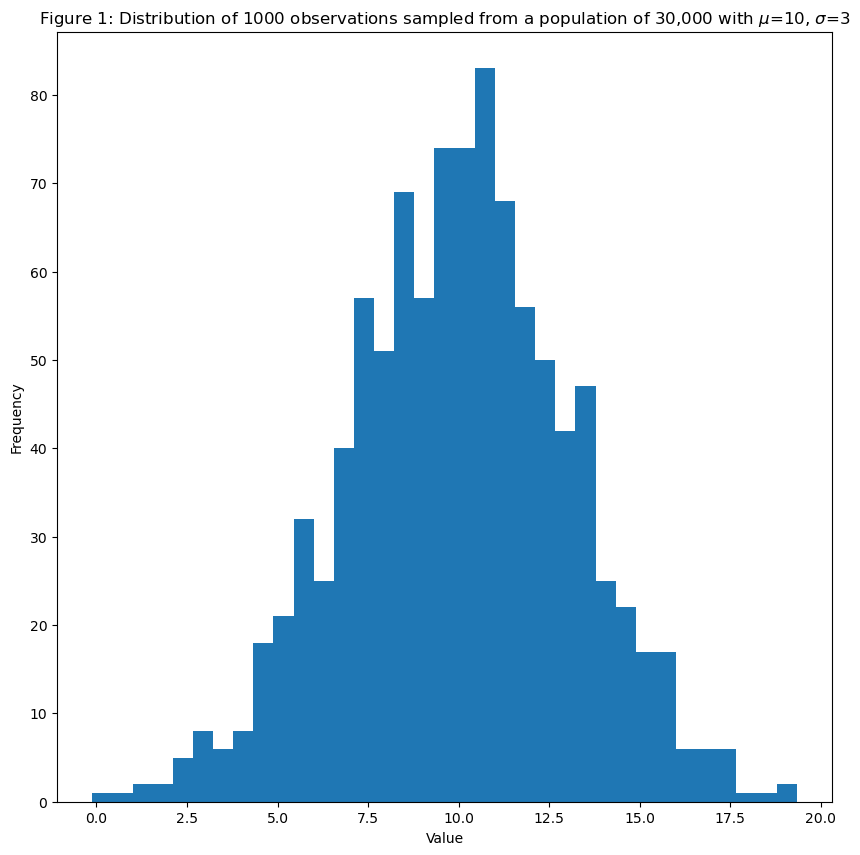

In [2]:
mod1=lambda t:np.random.normal(10,3,t)

#Form a population of 30,000 individual, with average=10 and scale=3
population = mod1(30000)
#Assume we are only able to observe 1,000 of these individuals.
observation = population[np.random.randint(0, 30000, 1000)]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.hist( observation,bins=35 ,)
ax.set_xlabel("Value")
ax.set_ylabel("Frequency")
ax.set_title("Figure 1: Distribution of 1000 observations sampled from a population of 30,000 with $\mu$=10, $\sigma$=3")
mu_obs=observation.mean()
mu_obs

## Step 2: What do we want?

We would like to find a distribution for $\sigma_{obs}$ using the 1000 observed samples. Those of you who are adept at mathematics will say that there is a formula for computing $\sigma$ ( $\sigma=\sqrt{\dfrac{1}{n}\sum_i^n(d_i-\mu)^2}$)! Why do we want to sample and whatnot?? Well, this is just a dummy data example, the real problem is in part 3, where the parameters cannot be computed directly. Plus here, we are not trying to find *a* value for $\sigma$, but rather, **we are trying to compute a distribution of the possible values of $\sigma$.**

## Step 3: Define the PDF and the transition model.

From Figure 1, we can see that the data is normally distributed. The mean can be easily computed by taking the average of the values of the 1000 samples. By doing that, we get for example $\mu_{obs}=9.8$.

### For the transition model/ proposal distribution:
I have no specific distribution in mind, so I will choose a simple one: the Normal distribution!

\begin{equation} Q(\sigma_{new} / \sigma_{current}) = N(\mu=\sigma_{current},\sigma'=1) \end{equation}

Note that $\sigma'$ is unrelated to $\sigma_{new}$ and $\sigma_{current}$. It simply specifies the standard deviation of the parameter space. It can be any value desired. It only affects the convergence time of the algorithm.

### For the PDF: 
Since f should be proportional to the posterior, we choose f to be the following Probability Density Function (PDF), for each data point $d_i$ in the data D:

\begin{equation} f(d_i/ \mu,\sigma^2) = \dfrac{1}{\sqrt{2\pi\sigma^2}}e^{-\dfrac{(d_i-\mu)^2}{2\sigma^2}} \end{equation}

In our case, $\theta$ is made up of two values: $[\mu,\sigma]$, and that $\mu$ is a constant, $\mu = \mu_{obs}$.

## Step 4: Define when we accept or reject $\sigma_{new}$: 
We accept $\sigma_{new}$ if:

$\dfrac{Likelihood(D/\mu_{obs},\sigma_{new})*prior(\mu_{obs},\sigma_{new})}{Likelihood(D/\mu_{obs},\sigma_{current})*prior(\mu_{obs},\sigma_{current})}>1     \quad \quad \quad \quad \quad      (1)$

If this ratio is smaller or equal to 1, then we compare it to a uniformly generated random number in the closed set [0,1]. If the ratio is larger than the random number, we accept $\sigma_{new}$, otherwise we reject it.

<font color=red>*Note: Since we will be computing this ratio to decide which parameters should be accepted, it is imperative to make sure that the adopted function $f$  is proportional to the posterior itself, $P(\sigma/ D,\mu)$, which in that case is verified. ($f$ is the PDF of P)*</font> [don't under above setenece yet]


## Step 5: Define the prior and the likelihood:
### For the Prior $P(\theta)$ which we can alternatively note $P(\sigma)$ since $\mu$ is constant:
We don't have any preferences for the values that $\sigma_{new}$ and $\sigma_{current}$ can take. The only thing worth noting is that they should be positive. Why? Intuitively, the standard deviation measures dispersion. Dispersion is a distance, and distances cannot be negative. Mathematically, $\sigma=\sqrt{\dfrac{1}{n}\sum_i^n(d_i-\mu)^2}$, and the square root of a number cannot be negative. We strictly enforce this in the prior.


### For the likelihood :
The total likelihood for a set of observation $D$ is: 
$$Likelihood(D/\mu_{obs},\sigma_{a}) = \prod_i^n f(d_i/\mu_{obs},\sigma_{a}) $$, where $a=new \: or \: current$.

**In our case, we will log both the prior and the likelihood function. Why log? Simply because it helps with numerical stability, i.e. multiplying thousands of small values (probabilities, likelihoods, etc..) can cause an underflow in the system's memory, and the log is a perfect solution because it transforms multiplications to additions and small positive numbers into non-small negative numbers.**

Therefore our acceptance condition from equation $(1)$ becomes:

Accept $\sigma_{new}$ if:

$$Log(Likelihood(D/\mu_{obs},\sigma_{new})) + Log(prior(\mu_{obs},\sigma_{new})) - (Log(Likelihood(D/\mu_{obs},\sigma_{current}))+ Log(prior(\mu_{obs},\sigma_{current})))>0$$

  Equivalent to: 
 
 $$\sum_i^nLog(f(d_i/\mu_{obs},\sigma_{new})) + Log(prior(\mu_{obs},\sigma_{new})) - \sum_i^nLog(f(d_i/\mu_{obs},\sigma_{current}))-Log(prior(\mu_{obs},\sigma_{current}))>0$$
 
 
  Equivalent to:
  
  $$\sum_i^nLog(f(d_i/\mu_{obs},\sigma_{new})) + Log(prior(\mu_{obs},\sigma_{new})) > \sum_i^nLog(f(d_i/\mu_{obs},\sigma_{current}))+Log(prior(\mu_{obs},\sigma_{current}))$$
  
  Equivalent to: 
  
  $$\sum_i^n -nLog(\sigma_{new}\sqrt{2\pi})-\dfrac{(d_i-\mu_{obs})^2}{2\sigma_{new}^2} + Log(prior(\mu_{obs},\sigma_{new})) \quad > 
  \sum_i^n -nLog(\sigma_{current}\sqrt{2\pi})-\dfrac{(d_i-\mu_{obs})^2}{2\sigma_{current}^2}+Log(prior(\mu_{obs},\sigma_{current}))  \tag{2}$$
  
  This form can be reduced even more by taking the square root and the multiplication out of the log.


In [23]:
#The tranistion model defines how to move from sigma_current to sigma_new
transition_model = lambda x: [x[0],np.random.normal(x[1],0.5,(1,))[0]]

def prior(x):
    #x[0] = mu, x[1]=sigma (new or current)
    #returns 1 for all valid values of sigma. Log(1) =0, so it does not affect the summation.
    #returns 0 for all invalid values of sigma (<=0). Log(0)=-infinity, and Log(negative number) is undefined.
    #It makes the new sigma infinitely unlikely.
    if(x[1] <=0):
        return 0
    return 1

#Computes the likelihood of the data given a sigma (new or current) according to equation (2)
def manual_log_like_normal(x,data):
    #x[0]=mu, x[1]=sigma (new or current)
    #data = the observation
    return np.sum(-np.log(x[1] * np.sqrt(2* np.pi) )-((data-x[0])**2) / (2*x[1]**2))

#Same as manual_log_like_normal(x,data), but using scipy implementation. It's pretty slow.
def log_lik_normal(x,data):
    #x[0]=mu, x[1]=sigma (new or current)
    #data = the observation
    return np.sum(np.log(scipy.stats.norm(x[0],x[1]).pdf(data)))


#Defines whether to accept or reject the new sample
def acceptance(x, x_new):
    if x_new>x:
        return True
    else:
        accept=np.random.uniform(0,1)
        # Since we did a log likelihood, we need to exponentiate in order to compare to the random number
        # less likely x_new are less likely to be accepted
        return (accept < (np.exp(x_new-x)))


def metropolis_hastings(likelihood_computer,prior, transition_model, param_init,iterations,data,acceptance_rule):
    # likelihood_computer(x,data): returns the likelihood that these parameters generated the data
    # transition_model(x): a function that draws a sample from a symmetric distribution and returns it
    # param_init: a starting sample
    # iterations: number of accepted to generated
    # data: the data that we wish to model
    # acceptance_rule(x,x_new): decides whether to accept or reject the new sample
    x = param_init
    accepted = []
    rejected = []   
    for i in range(iterations):
        x_new =  transition_model(x)    
        x_lik = likelihood_computer(x,data)
        x_new_lik = likelihood_computer(x_new,data) 
        if (acceptance_rule(x_lik + np.log(prior(x)),x_new_lik+np.log(prior(x_new)))):            
            x = x_new
            accepted.append(x_new)
        else:
            rejected.append(x_new)            
                
    return np.array(accepted), np.array(rejected)

## Step 6: Run the algorithm with initial parameters and collect accepted and rejected samples

In [24]:
accepted, rejected = metropolis_hastings(manual_log_like_normal,prior,transition_model,[mu_obs,0.1], 50000,observation,acceptance)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in log


### The algorithm accepted 8803 samples (which might be different on each new run). The last 10 samples contain the following  values for $\sigma$:

In [25]:
accepted[-10:,1]

array([3.12825546, 3.23574383, 3.23190749, 3.14136148, 3.10197045,
       3.181015  , 2.94143149, 2.95667786, 3.00426027, 3.0758097 ])

In [26]:
print(accepted.shape)

(8590, 2)


(8590, 2)

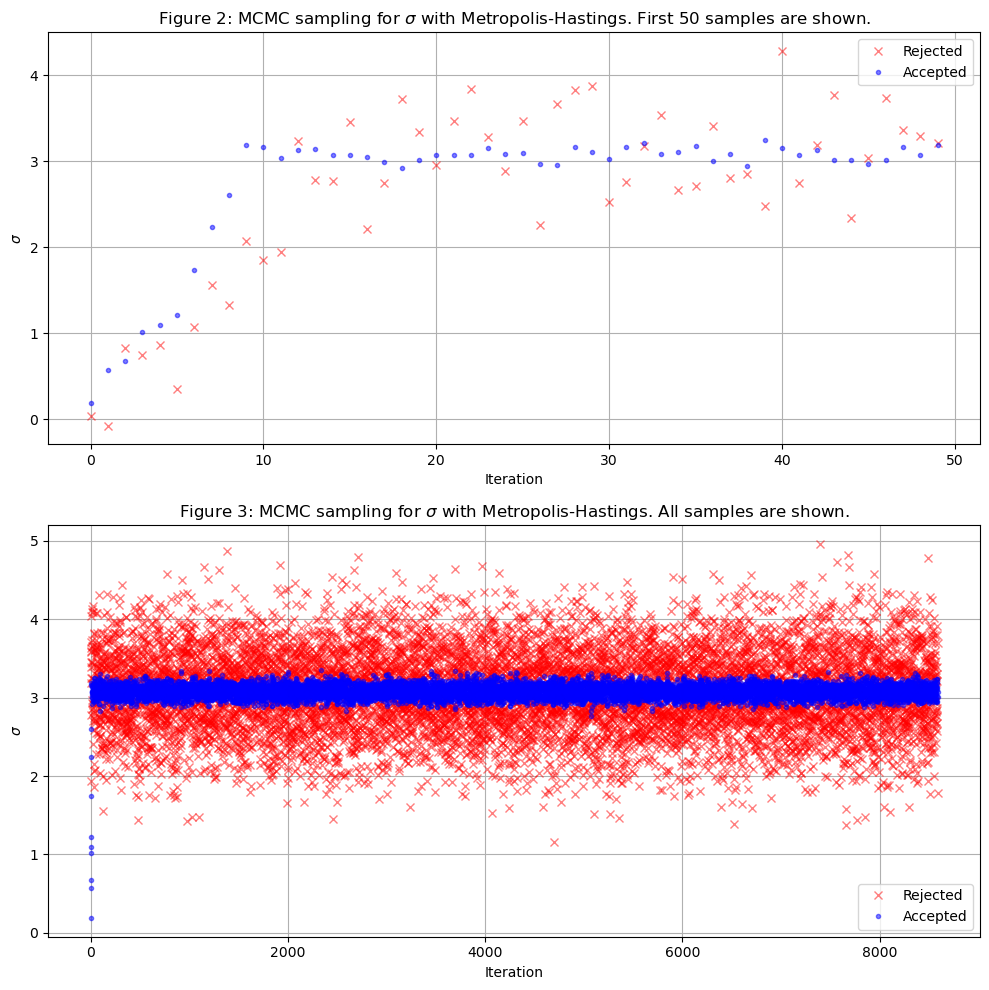

In [27]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2,1,1)

ax.plot( rejected[0:50,1], 'rx', label='Rejected',alpha=0.5)
ax.plot( accepted[0:50,1], 'b.', label='Accepted',alpha=0.5)
ax.set_xlabel("Iteration")
ax.set_ylabel("$\sigma$")
ax.set_title("Figure 2: MCMC sampling for $\sigma$ with Metropolis-Hastings. First 50 samples are shown.")
ax.grid()
ax.legend()



ax2 = fig.add_subplot(2,1,2)
to_show=-accepted.shape[0]
ax2.plot( rejected[to_show:,1], 'rx', label='Rejected',alpha=0.5)
ax2.plot( accepted[to_show:,1], 'b.', label='Accepted',alpha=0.5)
ax2.set_xlabel("Iteration")
ax2.set_ylabel("$\sigma$")
ax2.set_title("Figure 3: MCMC sampling for $\sigma$ with Metropolis-Hastings. All samples are shown.")
ax2.grid()
ax2.legend()



fig.tight_layout()
accepted.shape

So, starting from an initial σ of 0.1, the algorithm converged pretty quickly to the expected value of 3. That said, it's only sampling in a 1D space…. so it's not very surprising.

### We consider the initial 25% of the values of $\sigma$ to be "burn-in", so we drop them.
### Let's visualize the trace of  $\sigma$ and the histogram of the trace.

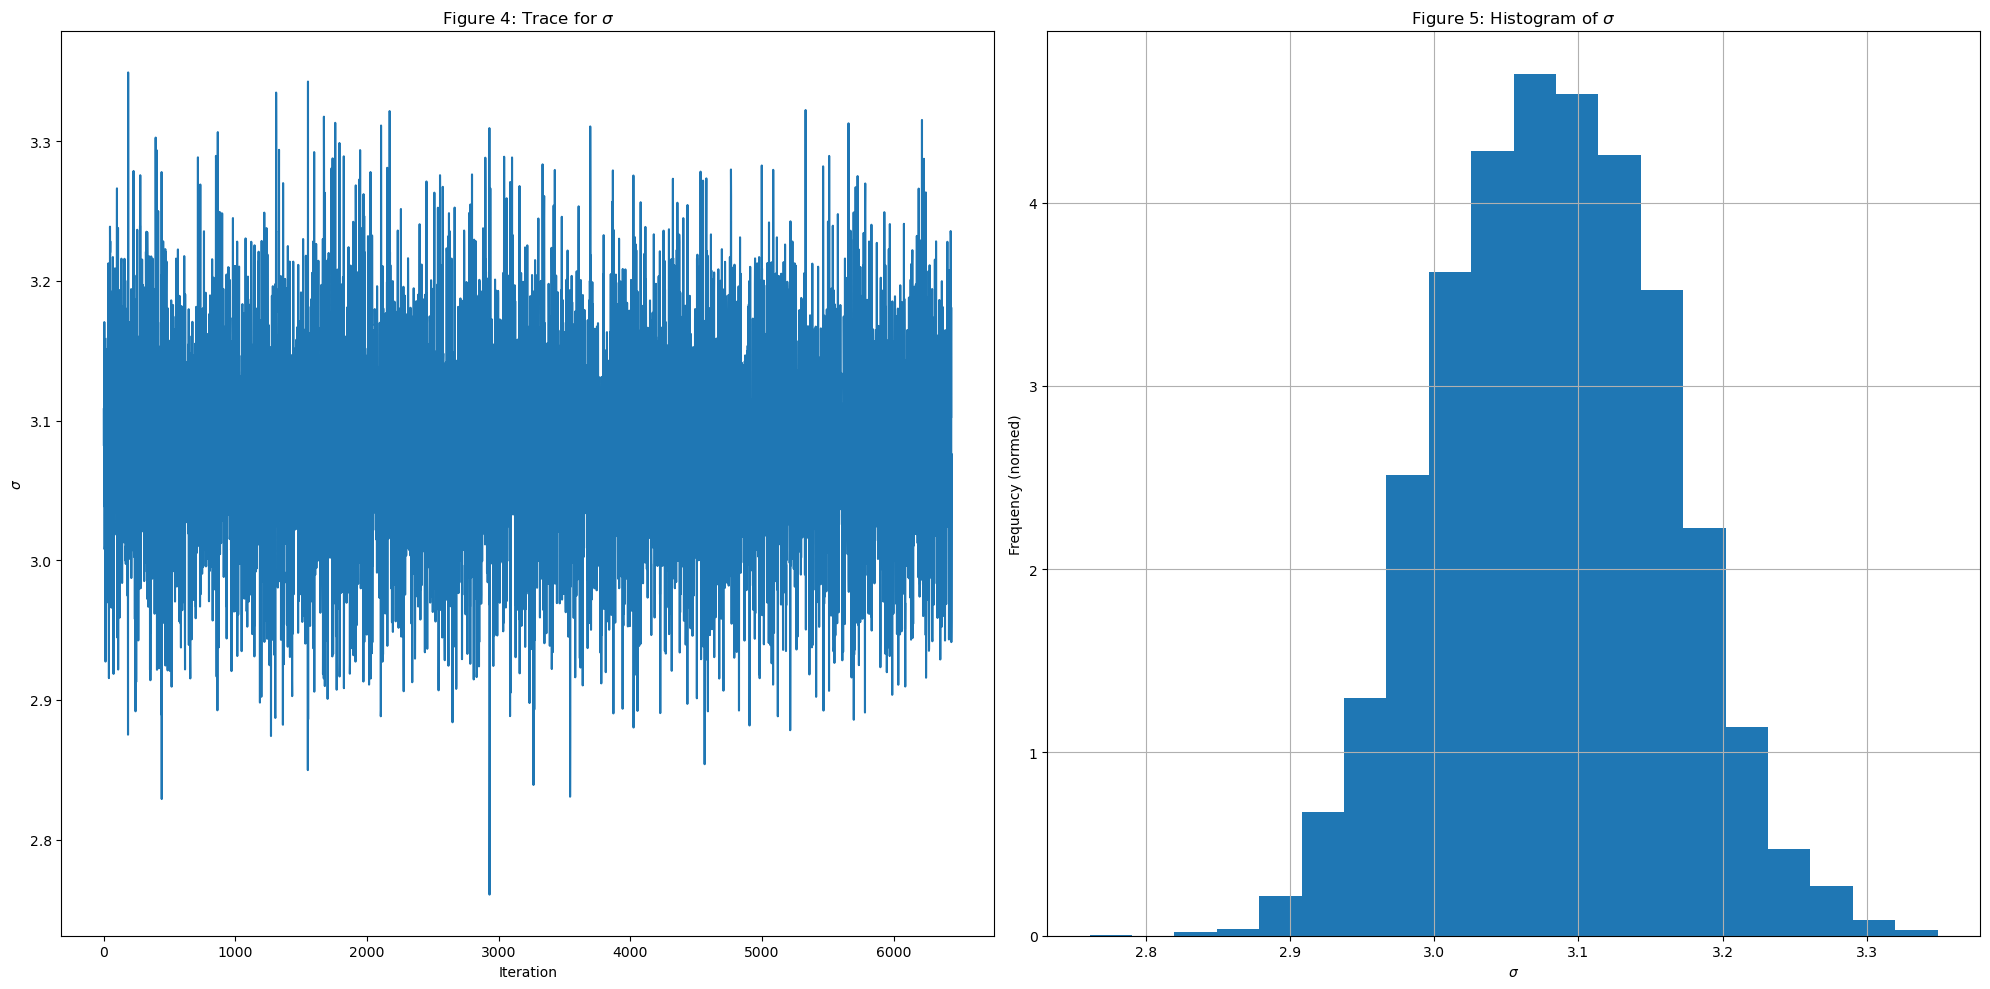

In [28]:

show=int(-0.75*accepted.shape[0])
hist_show=int(-0.75*accepted.shape[0])

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,2,1)
ax.plot(accepted[show:,1])
ax.set_title("Figure 4: Trace for $\sigma$")
ax.set_ylabel("$\sigma$")
ax.set_xlabel("Iteration")
ax = fig.add_subplot(1,2,2)
ax.hist(accepted[hist_show:,1], bins=20,density=True)
ax.set_ylabel("Frequency (normed)")
ax.set_xlabel("$\sigma$")
ax.set_title("Figure 5: Histogram of $\sigma$")
fig.tight_layout()


ax.grid("off")


### The most likely value for $\sigma$ is around 3.1. This is a bit more than the original value of 3.0. The difference is due to us observing only 3.33% of the original population (1,000 out of 30,000) 

## Predictions:
First, we average the last 75% of accepted samples of σ, and we generate 30,000 random individuals from a normal distribution with μ=9.8 and σ=3.05 (the average of the last 75% of accepted samples) which is actually better than the most likely value of 3.1.

9.976226220606645 3.0824154119925873


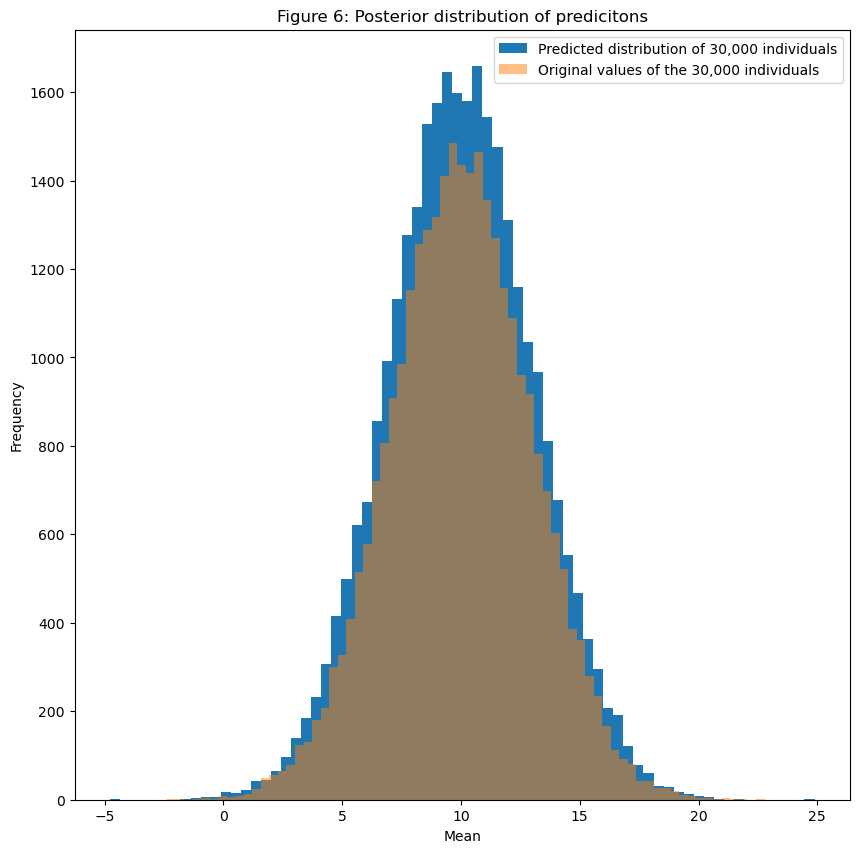

In [29]:
mu=accepted[show:,0].mean()
sigma=accepted[show:,1].mean()
print(mu, sigma)
model = lambda t,mu,sigma:np.random.normal(mu,sigma,t)
observation_gen=model(population.shape[0],mu,sigma)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.hist( observation_gen,bins=70 ,label="Predicted distribution of 30,000 individuals")
ax.hist( population,bins=70 ,alpha=0.5, label="Original values of the 30,000 individuals")
ax.set_xlabel("Mean")
ax.set_ylabel("Frequency")
ax.set_title("Figure 6: Posterior distribution of predicitons")
ax.legend()

# Part 3: A real world example

A sunspot is a region on the Sun's surface (photosphere) that is marked by a lower temperature than its environment. These reduced temperatures are caused by concentrations of magnetic field flux that inhibit convection by an effect similar to [eddy current brakes](https://en.wikipedia.org/wiki/Eddy_current). Sunspots usually appear in pairs of opposite magnetic polarity. Their number varies according to the approximately 11-year solar cycle.

The data we will be working on is the "Monthly mean total sunspot number", for each month from January 1749 to November 2018. This is data collected, curated and made publicly available by the [World Data Center for the production, preservation and dissemination of the international sunspot number](http://www.sidc.be/silso/home).

## Let's plot the data over the years to see what the distribution might be like.

(3238,) (3238,)
1785.042


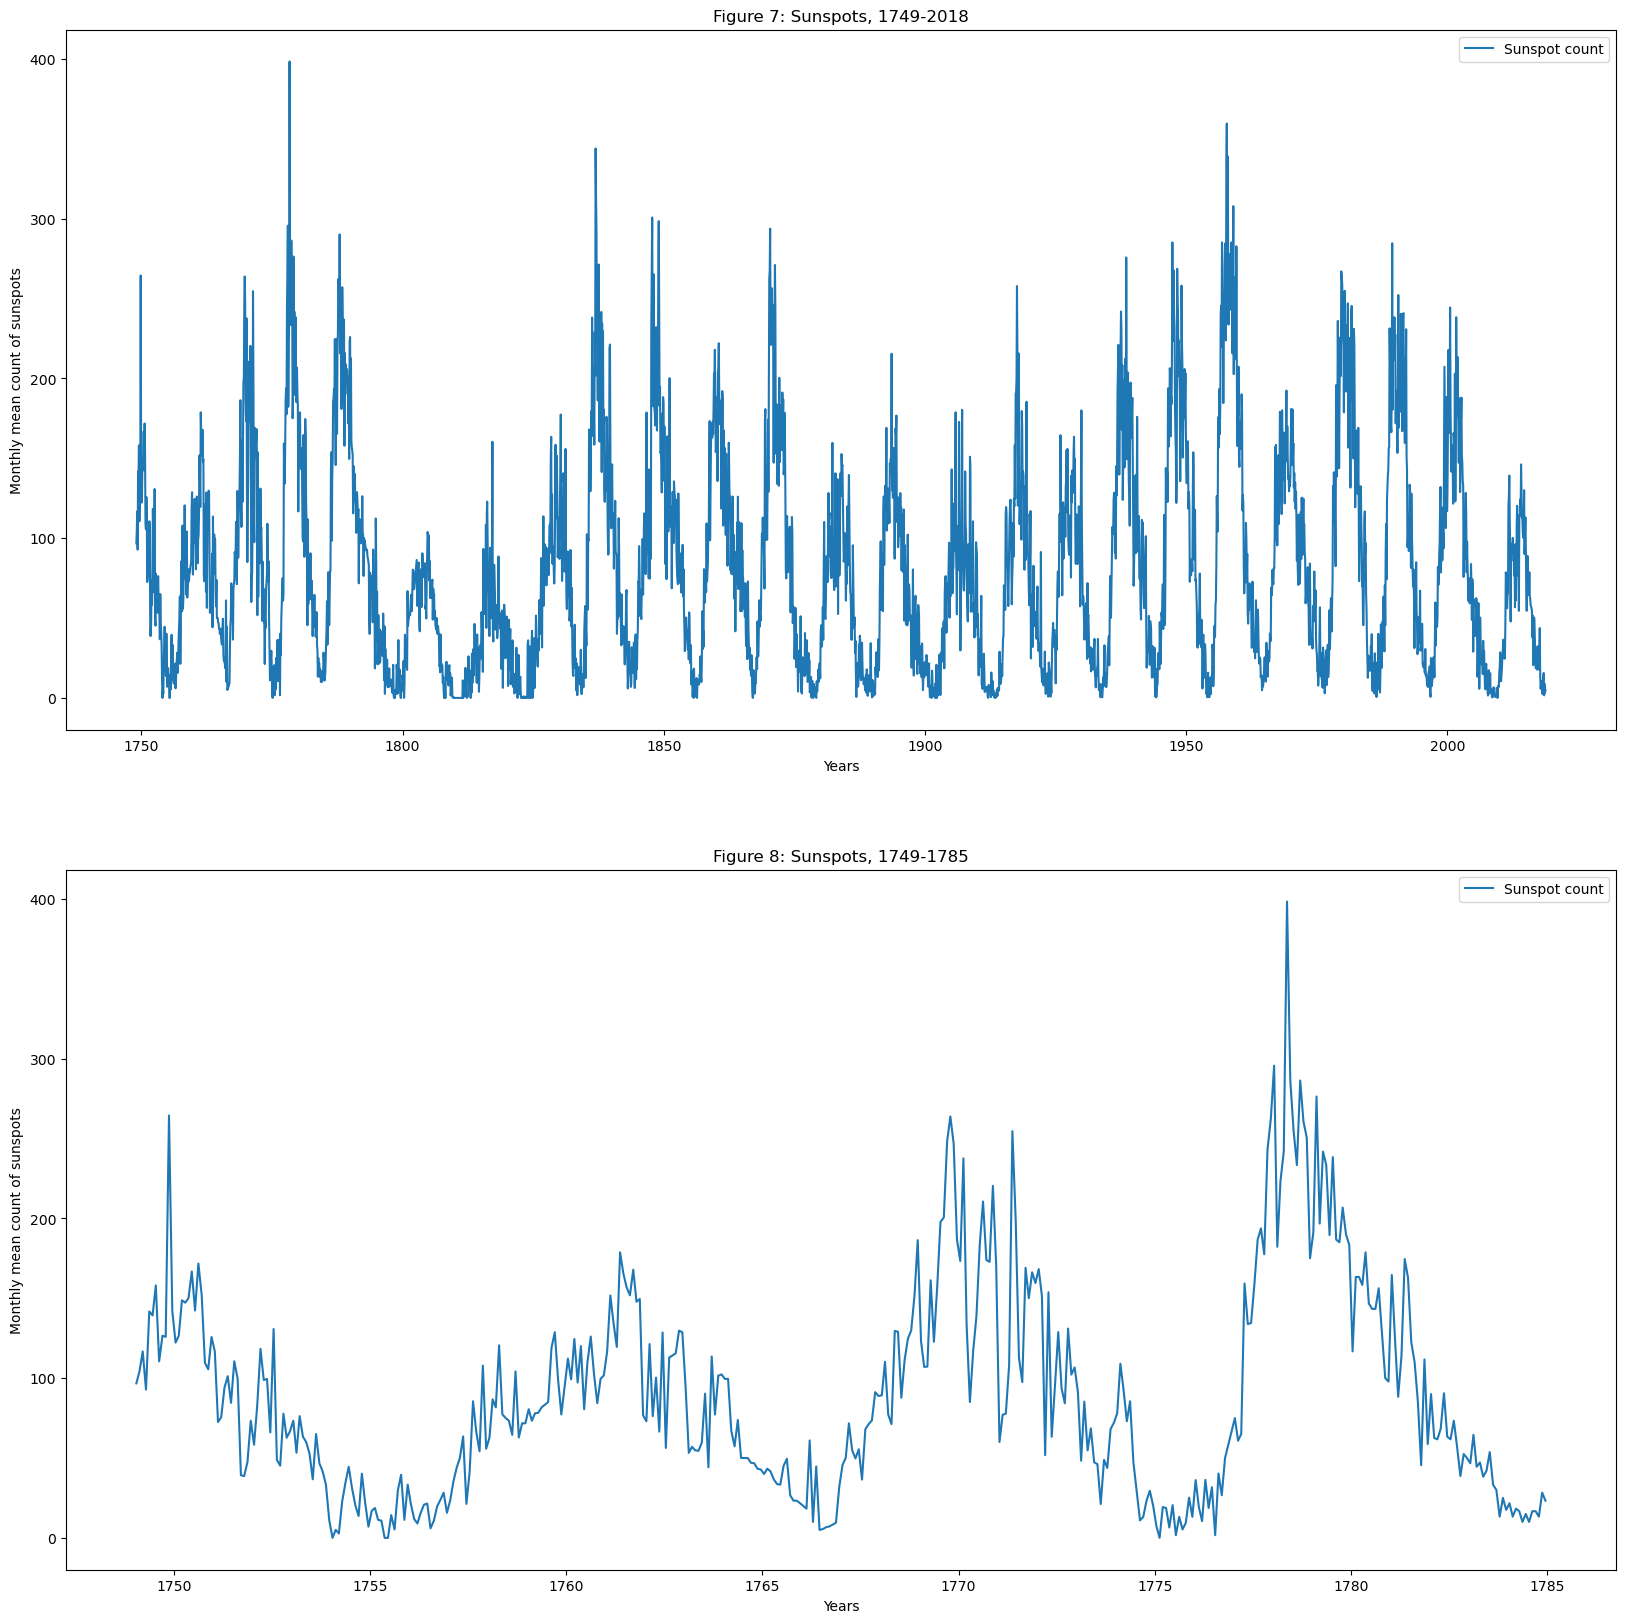

In [14]:
sunspots = np.loadtxt("data/SN_m_tot_V2.0.csv", delimiter=';')

#years is the third column
years = sunspots[:,2]
#activity is the 4th column
activity = sunspots[:,3] + 0.1
print(years.shape,activity.shape)
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(2,1,1)

ax.plot(years, activity, label="Sunspot count")
ax.set_yticks(np.arange(0,500,100))
ax.set_xlabel("Years")
ax.set_ylabel("Monthly mean count of sunspots")
ax.set_title("Figure 7: Sunspots, 1749-2018")
ax.legend()


ax = fig.add_subplot(2,1,2)
print(years[432])
ax.plot(years[:432], activity[:432], label="Sunspot count")
ax.set_yticks(np.arange(0,500,100))
ax.set_xlabel("Years")
ax.set_ylabel("Monthly mean count of sunspots")
ax.set_title("Figure 8: Sunspots, 1749-1785")
ax.legend()

In [30]:
years[432]

1785.042

## It seems like we could model this phenomenon with a gamma distribution, with a new cycle resetting every 12 years. 


A gamma distribution Γ is a two-parameter family of continuous probability distributions, the parameters are the shape a and the scale b. A random variable X that is gamma-distributed is noted X~Γ(a, b), and in our case X is the count of sunspots. The two parameters a and b are the unknowns that we would like to calculate distributions for.
<img src="data/gamma.PNG">*Credit: Wikipedia Commons.*

 
For example, in the first cycle, the sunspot counts start from their highest at about 300 at the end of 1749, and fall to their lowest 6 years after, during 1755. Then the number rises up again to it's maximum during 1761 and 1762 before falling again during 1766 and so on...

## Let's make sure by plotting a histogram of sunspot counts:

Text(0.5, 1.0, 'Figure 9: Histogram showing the frequency of sunspot counts over 270 years (1749-2018)')

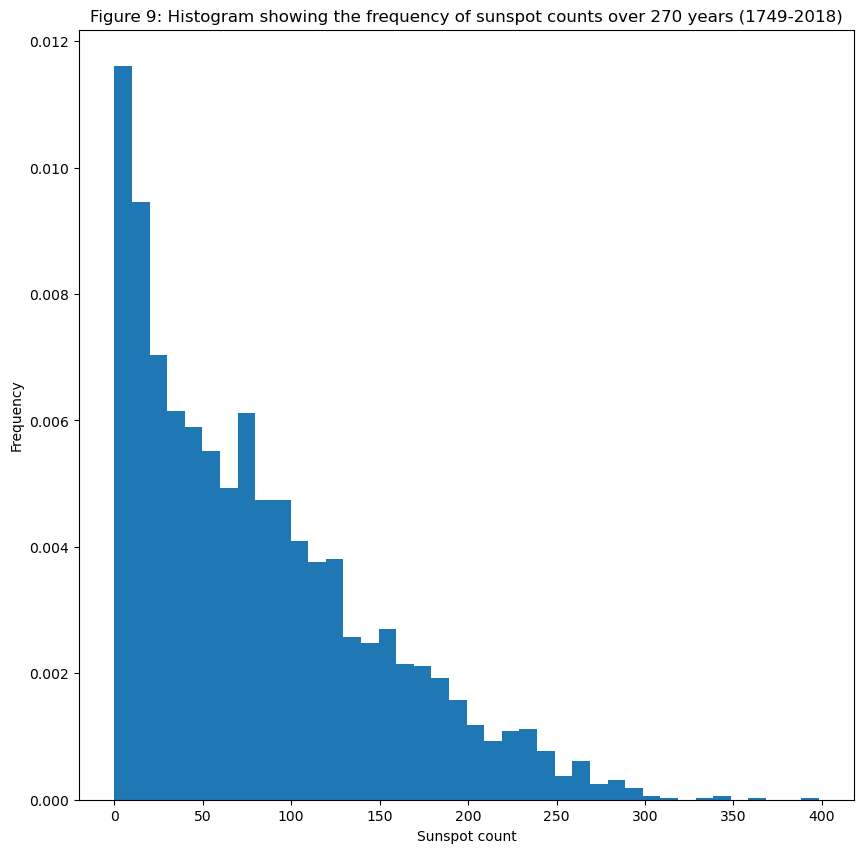

In [15]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.hist(activity, bins=40, density=True)
ax.set_xlabel("Sunspot count")
ax.set_ylabel("Frequency")
ax.set_title("Figure 9: Histogram showing the frequency of sunspot counts over 270 years (1749-2018)")

## Indeed, it does seem like the frequency of counts follows a gamma distribution

The gamma distribution, has for PDF, $f/f(x;a,b) =\dfrac{b^a x^{a-1}e^{-b x}}{\Gamma{(a)}}$ where $\Gamma$ is the gamma function (not to be confused with the gamma distribution which requires 2 parameters): $\Gamma{(a)}=(a-1)!$

Following the same procedure as in the dummy data example, we can write down the log likelihood from this pdf (see code below). Alternatively, one could use the $scipy.stats.gamma(a,b).pdf(x)$ function to compute it.

Since a and b must be positive, we enforce this in the prior.

In [31]:
transition_model = lambda x: np.random.normal(x,[0.05,5],(2,))
import math
def prior(w):
    if(w[0]<=0 or w[1] <=0):
        return 0
    else:
        return 1
    
def manual_log_lik_gamma(x,data):
    return np.sum((x[0]-1)*np.log(data) - (1/x[1])*data - x[0]*np.log(x[1]) - np.log(math.gamma(x[0])))
    
def log_lik_gamma(x,data):
    return np.sum(np.log(scipy.stats.gamma(a=x[0],scale=x[1],loc=0).pdf(data)))    


In [32]:
accepted, rejected = metropolis_hastings(manual_log_lik_gamma,prior,transition_model,[4, 10], 50000,activity,acceptance)

In [33]:
print(accepted.shape)
accepted[-10:]

(8609, 2)


array([[ 1.02490778, 83.8511566 ],
       [ 1.00278779, 78.08327369],
       [ 0.98022741, 80.21196491],
       [ 0.96402155, 81.07479172],
       [ 0.95529461, 81.63607986],
       [ 0.99872851, 78.39366091],
       [ 0.97600451, 82.37299469],
       [ 0.961985  , 83.88958938],
       [ 0.94603285, 86.84908186],
       [ 0.9749906 , 84.71025594]])

Starting from a=4, and b =10, the algorithm accepted 8561 pairs of samples, the last value for a is 1.01307402 and the last value for b is 83.40995308, which are pretty far off the initial values.

## As with the dummy data example, let's see how the algorithm worked its way to these values:

Text(0.5, 1.0, 'Figure 12: MCMC sampling for $a$ and $b$ with Metropolis-Hastings. Last 50 samples are shown.')

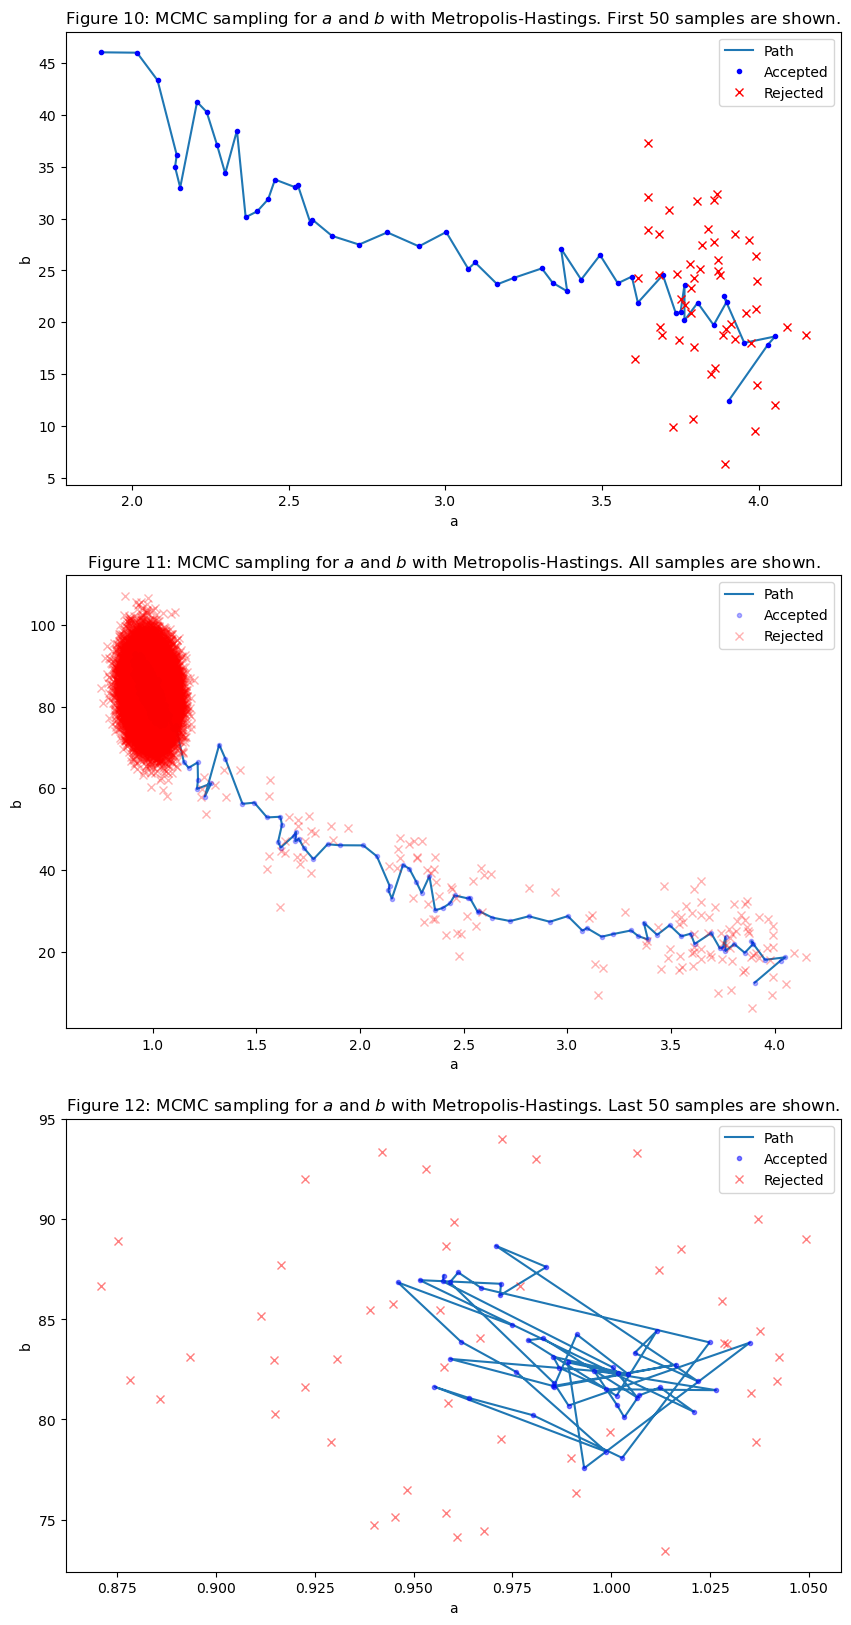

In [34]:

fig = plt.figure(figsize=(10,20))
ax = fig.add_subplot(3,1,1)
ax.plot(accepted[:50,0], accepted[:50,1], label="Path")
ax.plot(accepted[:50,0], accepted[:50,1], 'b.', label='Accepted')
ax.plot(rejected[:50,0], rejected[:50,1], 'rx', label='Rejected')
ax.set_xlabel("a")
ax.set_ylabel("b")
ax.legend()
ax.set_title("Figure 10: MCMC sampling for $a$ and $b$ with Metropolis-Hastings. First 50 samples are shown.")  


ax = fig.add_subplot(3,1,2)
ax.plot(accepted[:,0], accepted[:,1], label="Path")
ax.plot(accepted[:,0], accepted[:,1], 'b.', label='Accepted',alpha=0.3)
ax.plot(rejected[:,0], rejected[:,1], 'rx', label='Rejected',alpha=0.3)
ax.set_xlabel("a")
ax.set_ylabel("b")
ax.legend()
ax.set_title("Figure 11: MCMC sampling for $a$ and $b$ with Metropolis-Hastings. All samples are shown.") 

to_show=50
ax = fig.add_subplot(3,1,3)
ax.plot(accepted[-to_show:,0], accepted[-to_show:,1], label="Path")
ax.plot(accepted[-to_show:,0], accepted[-to_show:,1], 'b.', label='Accepted',alpha=0.5)
ax.plot(rejected[-to_show:,0], rejected[-to_show:,1], 'rx', label='Rejected',alpha=0.5)
ax.set_xlabel("a")
ax.set_ylabel("b")
ax.legend()
ax.set_title("Figure 12: MCMC sampling for $a$ and $b$ with Metropolis-Hastings. Last 50 samples are shown.") 

As we can see from figures 10, 11, and 12, the algorithm converges quickly to the [a=1,b=85] zone.

Tip: when the algorithm starts to heavily reject samples, that means that we have reached a zone of saturation of the likelihood. Commonly, this can be interpreted as having reached the optimal parameter space from which we can sample, i.e. there is very little reason for the algorithm to accept new values. This is marked in figures 11, and 12 where the algorithm no longer accepts any values outside of a small range.

### We consider the initial 50% of the values of a and b to be "burn-in", so we drop them.
### Let's visualize the traces of  and b and the histogram of the traces.

Text(0.5, 1.0, '2D histogram showing the joint distribution of $a$ and $b$')

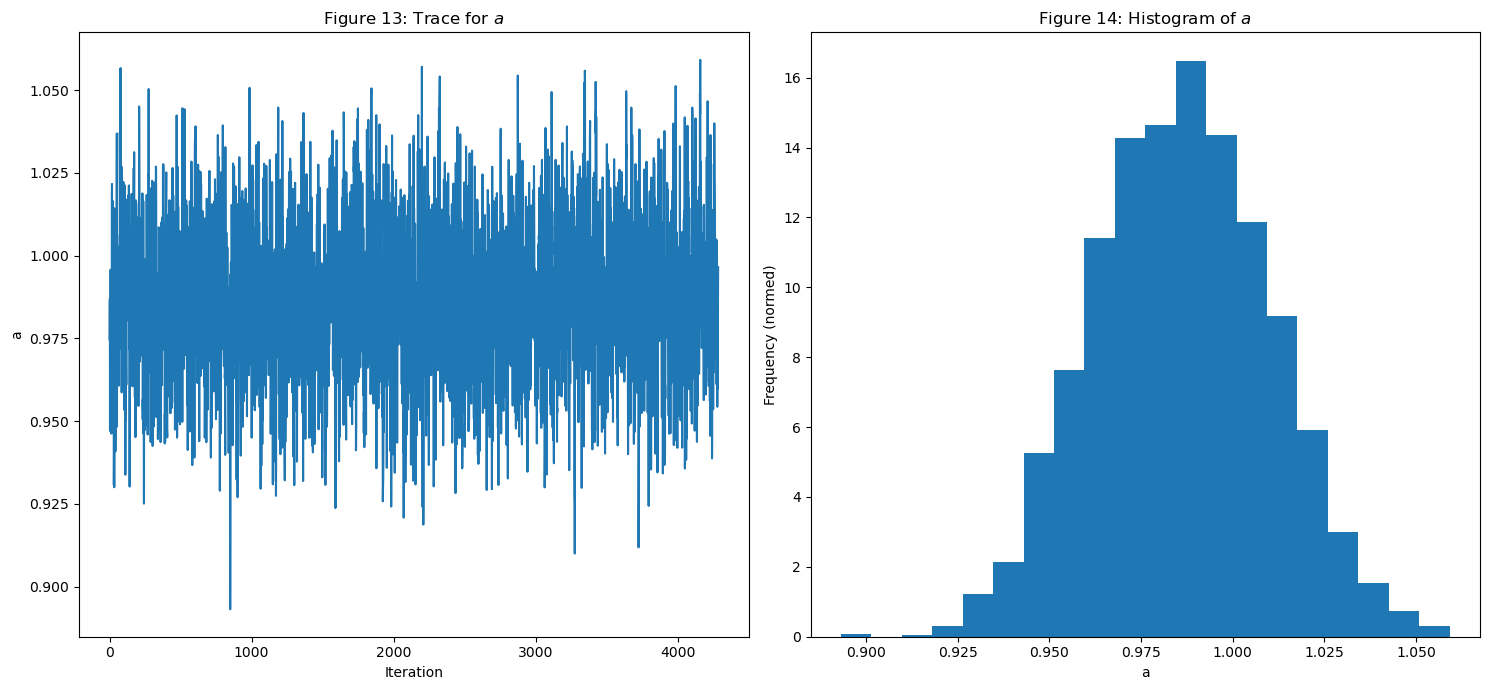

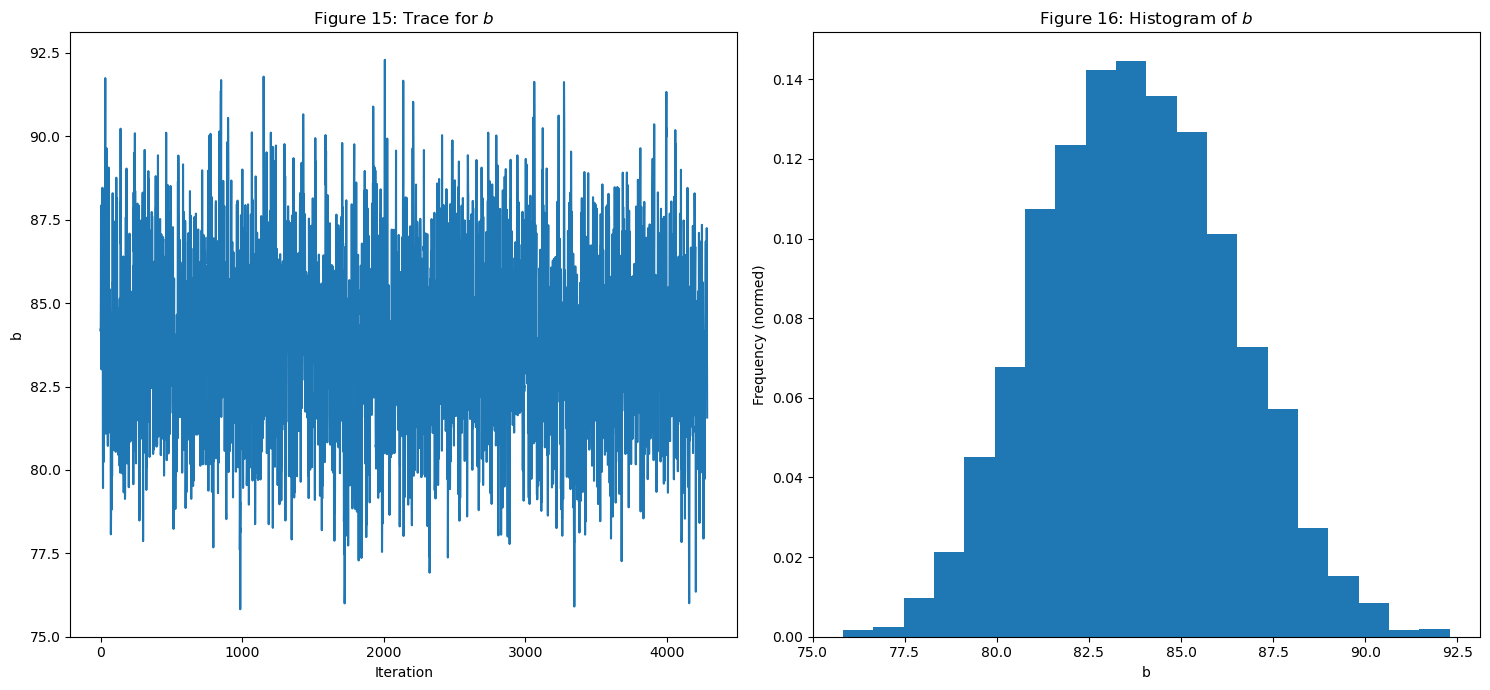

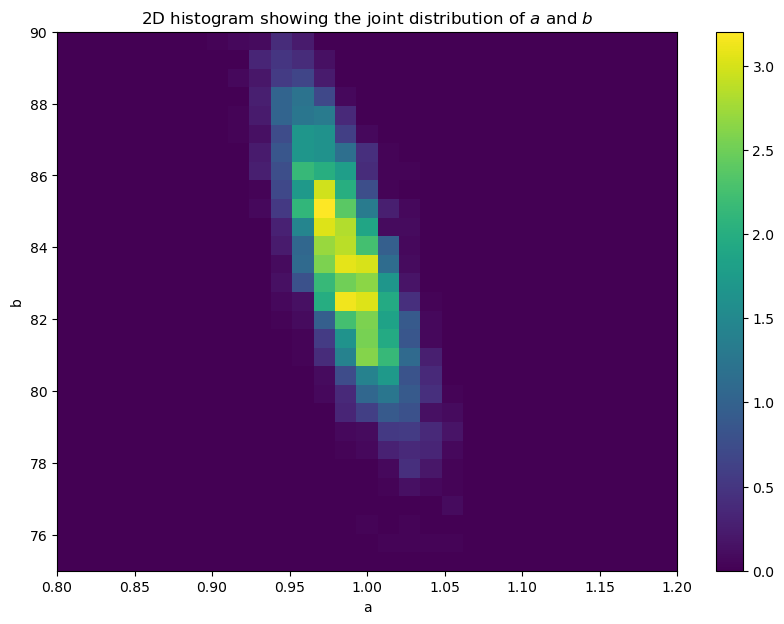

In [20]:
show=int(-0.5*accepted.shape[0])
hist_show=int(-0.50*accepted.shape[0])


fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1,2,1)
ax.plot(accepted[show:,0])
ax.set_title("Figure 13: Trace for $a$")
ax.set_xlabel("Iteration")
ax.set_ylabel("a")
ax = fig.add_subplot(1,2,2)
ax.hist(accepted[hist_show:,0], bins=20, density=True)
ax.set_ylabel("Frequency (normed)")
ax.set_xlabel("a")
ax.set_title("Figure 14: Histogram of $a$")
fig.tight_layout()

fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1,2,1)
ax.plot(accepted[show:,1])
ax.set_title("Figure 15: Trace for $b$")
ax.set_xlabel("Iteration")
ax.set_ylabel("b")
ax = fig.add_subplot(1,2,2)
ax.hist(accepted[hist_show:,1], bins=20, density=True)
ax.set_ylabel("Frequency (normed)")
ax.set_xlabel("b")
ax.set_title("Figure 16: Histogram of $b$")
fig.tight_layout()

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1,1,1)
xbins, ybins = np.linspace(0.8,1.2,30), np.linspace(75,90,30)
counts, xedges, yedges, im = ax.hist2d(accepted[hist_show:,0], accepted[hist_show:,1], density=True, bins=[xbins, ybins])
ax.set_xlabel("a")
ax.set_ylabel("b")
fig.colorbar(im, ax=ax)
ax.set_title("2D histogram showing the joint distribution of $a$ and $b$")

## Prediction time

First, we average the last 50% of accepted samples of a and b, and we generate random individuals from a Γ distribution. $a_{average}$=0.9866200759935773 and $b_{average}$=83.70749712447888.

0.9859124903678548 83.78299695212466


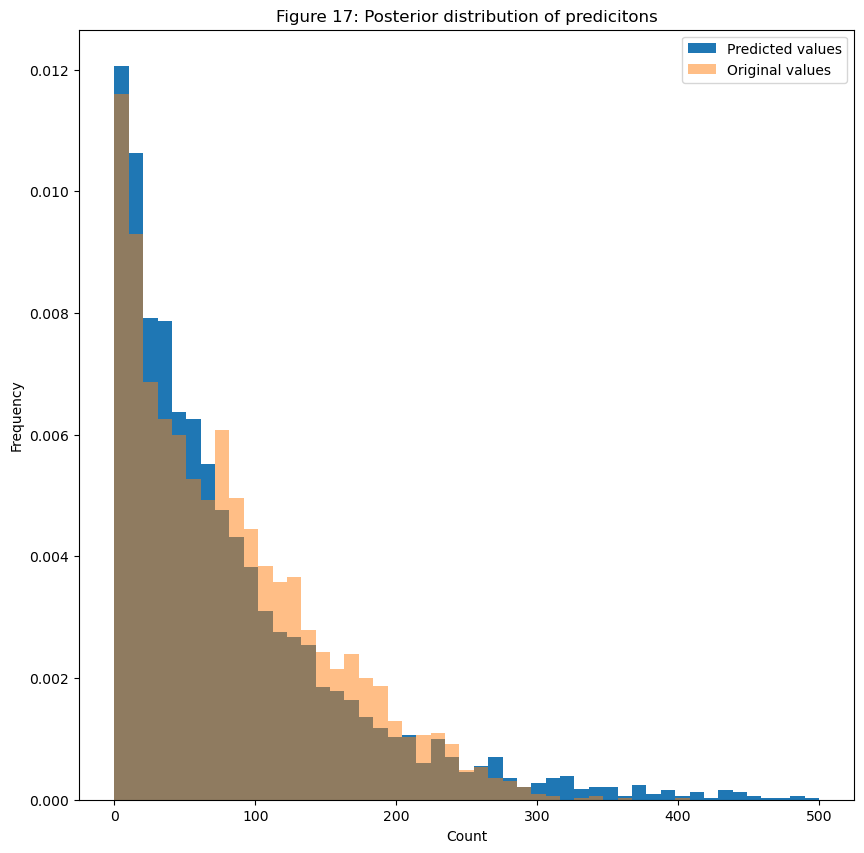

In [21]:
show=-int(0.5*accepted.shape[0])

mu=accepted[show:,0].mean()
sigma=accepted[show:,1].mean()
print(mu, sigma)
model = lambda t,mu,sigma:np.random.gamma(mu,sigma,t)
t=np.arange(activity.shape[0])
observation_gen=model(t.shape[0],mu,sigma)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)



ax.hist( observation_gen,bins=np.linspace(0,500,50) ,density=True,label="Predicted values")
ax.hist( activity,bins=np.linspace(0,500,50) ,alpha=0.5,density=True, label="Original values")
ax.set_xlabel("Count")
ax.set_ylabel("Frequency")
ax.set_title("Figure 17: Posterior distribution of predicitons")
ax.legend()

## Evaluation
### Evaluation of the proposal distribution
How do we specify the parameters for the distribution Q? Should we move far from the current sample θ, or stay relatively close? These questions can be answered by measuring the auto-correlation between accepted samples: we do not want the accepted samples to be too correlated between one another. We don't want distant samples to be too correlated as we are trying to implement a markov chain, i.e. a sample should only depend on its previous sample, and the auto-correlation plot should show a quick, exponential decrease between the correlation of sample i and i-1,i-2,...i-n

The auto-correlation is defined by computing the following function for each lag $k$:
$$r_k=\dfrac{\sum_{i=1}^{N-k}(Y_i-Y_{avg})(Y_{i+k}-Y_{avg})}{\sum_{i=1}^{N}(Y_i-Y_{avg})^2}$$

The lag $k$, is basically the *range* around a sample $Y_i$ in which we would like to measure the correlation.

The plots below show the auto-correlation for a, b for k going from 1 to 100. A lag of k=1 means that we are measuring the correlation of a sample with itself, so we expect it to be equal to 1. The higher k goes, the lower that correlation ought to be.

0.9867768431864482 83.74459363370107


[Text(0.5, 0, 'lag'), Text(0, 0.5, 'autocorrelation'), (-0.1, 1.0)]

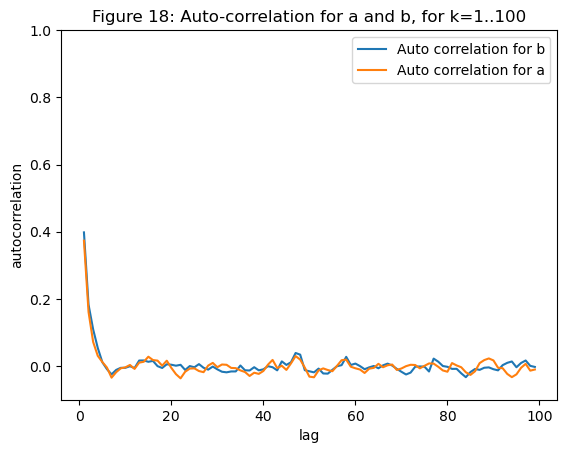

In [35]:
mean_acc_0=accepted[show:,0].mean()
mean_acc_1=accepted[show:,1].mean()
print(mean_acc_0,mean_acc_1)

lag=np.arange(1,100)
def autocorr(accepted,lag):
    num_0=0
    denom_0=0
    num_1=0
    denom_1=0
    for i in range(accepted.shape[0]-lag):
        num_0+=(accepted[i,0]-mean_acc_0)*(accepted[i+lag,0]-mean_acc_0)
        num_1+=(accepted[i,1]-mean_acc_1)*(accepted[i+lag,1]-mean_acc_1)
        denom_0+=(mean_acc_0-accepted[i,0])**2
        denom_1+=(mean_acc_1-accepted[i,1])**2
    rk_0=num_0/denom_0
    rk_1=num_1/denom_1
    return rk_0, rk_1


accepted_reversed=accepted[show:,:]
result=np.zeros((2,lag.shape[0]))
#print(lag)
for l in lag:
    result[:,l-1]=autocorr(accepted_reversed,l)
    
    
###Instead of writing an autocorrelation function, one could simply use thee autocorr function provided in pymc3    
#from pymc3.stats import autocorr

fig, ax = plt.subplots()
#ax.plot(lag, [autocorr(accepted[show:,1], l) for l in lags], label='auto b')
#ax.plot(lag, [autocorr(accepted[show:,0], l) for l in lags], label='auto a')
ax.plot(lag, result[1,:], label='Auto correlation for b')
ax.plot(lag, result[0,:], label='Auto correlation for a')
ax.legend(loc=0)
ax.set_title("Figure 18: Auto-correlation for a and b, for k=1..100")
ax.set(xlabel='lag', ylabel='autocorrelation', ylim=(-.1, 1))

In our case, we are lucky to have a low enough correlation. In general, we might want to setup the parameters of the proposal distribution, Q, automatically, **one common method is to keep adjusting the proposal parameters so that more than 50% proposals are rejected.** Alternatively, one could use **an enhanced version of MCMC called Hamiltonian Monte Carlo**, which reduces the correlation between successive sampled states and reaches the stationary distribution quicker.

## Conclusion
While the abstraction behind this algorithm may seem out of grasp at first, the implementation is actually pretty simple, and gives awesome results. In fact, the great thing about probabilistic programming, notably MCMC is that you only need to write down the model and then run it. There is no need to compute evidence, or ensure some constraining mathematical properties.


## Resources
Peter Driscoll, "A comparison of least-squares and Bayesian fitting techniques to radial velocity data sets" 

Carson Chow, "MCMC and fitting models to data"

John H. Williamson, "Data Fundamentals - Probabilities"

Simon Rogers, "A first course in machine learning"